Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/wei-tianyu/deep-remote-prior
!mv deep-remote-prior/* ./

Cloning into 'deep-remote-prior'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (541/541), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 541 (delta 227), reused 525 (delta 211), pack-reused 0
Receiving objects: 100% (541/541), 107.70 MiB | 16.41 MiB/s, done.
Resolving deltas: 100% (227/227), done.


In [2]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4905110321214147394
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9557691254586037516
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import time
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 4 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8 
path_to_image = 'data/sr/zebra_GT.png'
picname = 'zebra'

# Load image and baselines

HR and LR resolutions: (576, 384), (144, 96)


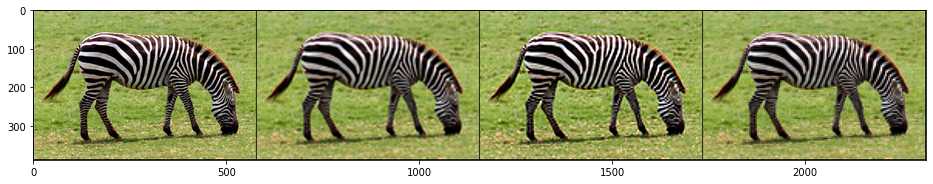

PSNR bicubic: 23.1048   PSNR nearest: 20.8212


In [4]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['bicubic_np']), 
                                        peak_signal_noise_ratio(imgs['HR_np'], imgs['nearest_np'])))

# Set up parameters and net

In [5]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [6]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

dip_psnr_lr_zebra.txt
Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


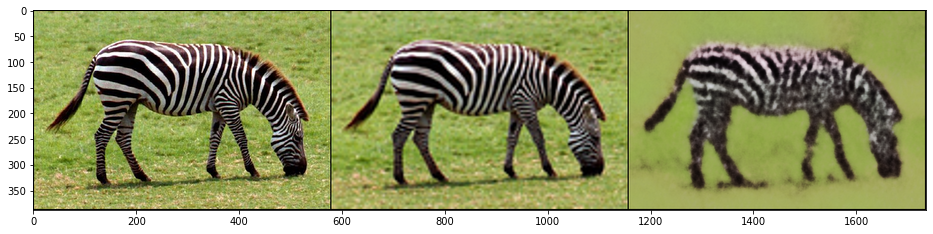

100 runtime: 21.347492218017578
Iteration 00100    Loss 0.013810   psnr_LR: 18.597985   psnr_HR: 17.122200 



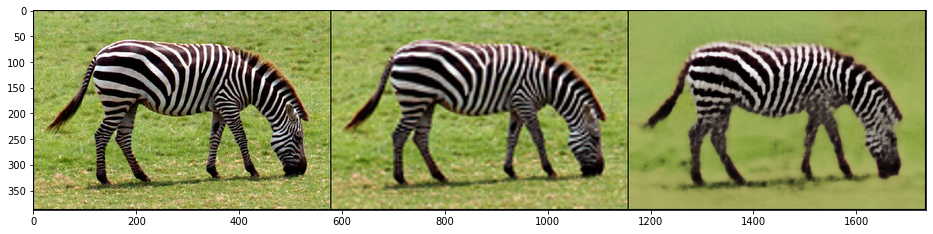

200 runtime: 38.584895610809326
Iteration 00200    Loss 0.005876   psnr_LR: 22.309327   psnr_HR: 19.710360 



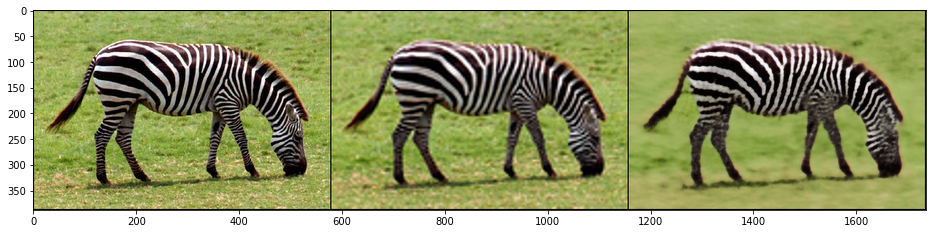

300 runtime: 56.049105167388916
Iteration 00300    Loss 0.003864   psnr_LR: 24.130011   psnr_HR: 20.855021 



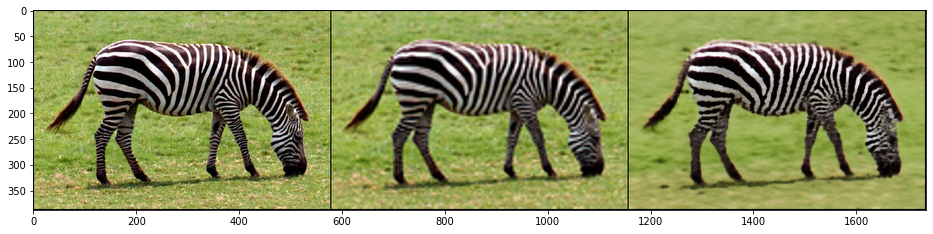

400 runtime: 73.6238911151886
Iteration 00400    Loss 0.002919   psnr_LR: 25.347757   psnr_HR: 21.503046 



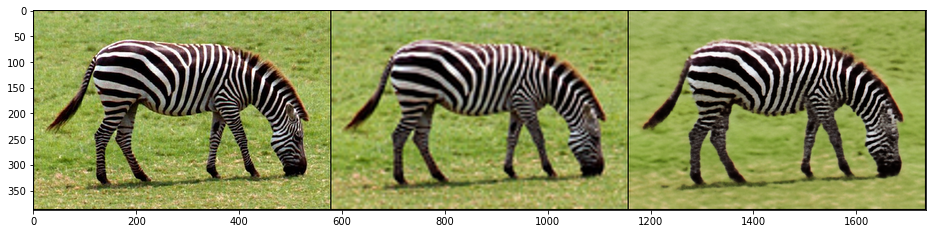

500 runtime: 91.34907174110413
Iteration 00500    Loss 0.002304   psnr_LR: 26.374970   psnr_HR: 22.057787 



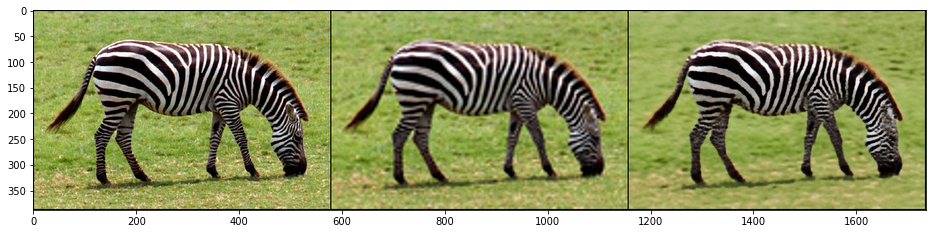

600 runtime: 109.2259042263031
Iteration 00600    Loss 0.001886   psnr_LR: 27.244117   psnr_HR: 22.392088 



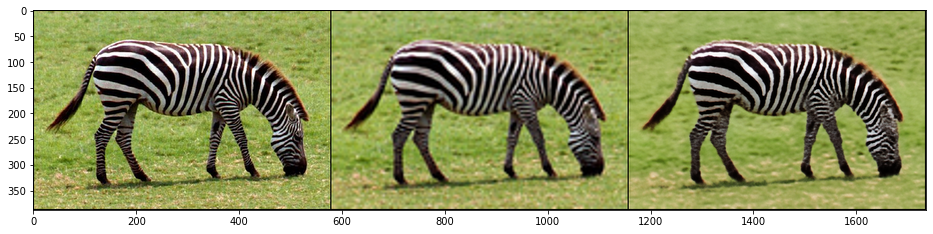

700 runtime: 127.40031743049622
Iteration 00700    Loss 0.001567   psnr_LR: 28.050124   psnr_HR: 22.755244 



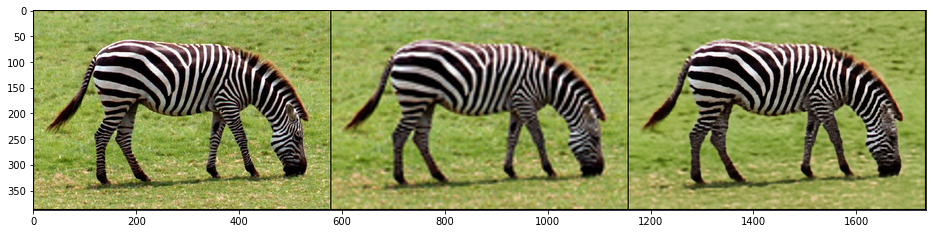

800 runtime: 145.58174967765808
Iteration 00800    Loss 0.001341   psnr_LR: 28.725466   psnr_HR: 22.977592 



In [ ]:
filename_lr = 'dip_psnr_lr_' + picname + '.txt'
filename_hr = 'dip_psnr_hr_' + picname + '.txt'
filename_loss = 'dip_psnr_loss_' + picname + '.txt'
print(filename_lr)
def closure():
    global i, net_input, start
    if (i == 1):
      start = time.time()
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = peak_signal_noise_ratio(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = peak_signal_noise_ratio(imgs['HR_np'], torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)
        # psrn_noise, psrn_gt, psrn_gt_sm, loss curve
        with open(filename_lr, 'a') as f:
          f.write(str(psnr_LR)+"\t")
          #f.write("\t")
        with open(filename_hr, 'a') as f:
          f.write(str(psnr_HR)+"\t")
          #f.write("\t")
        with open(filename_loss, 'a') as f:
          f.write(str(total_loss.item())+"\t")
          #f.write("\t")
        print (i, "runtime:", time.time() - start)
        print ('Iteration %05d    Loss %f   psnr_LR: %f   psnr_HR: %f' % (i, total_loss.item(), psnr_LR, psnr_HR),'\n')
    i += 1
    
    return total_loss

psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 1
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);

In [ ]:
print(i)